# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook I am going to present my code to implement a deep learning based approach for a traffic sign recognition system. 
My pipeline consists of several components that 

- Display information about the dataset or predictions on a specific dataset.
- Normalize the frequencies of class occurrences.
- Normalize the image data.
- Augment image data.
- Train the LeNet-Architecture neural network.
- Train a custom architecture, inspired by SqueezeNet.
- Log and visualize the training process of the neural network.
- Evaluate the final training state of a model.

To achieve all of these steps, I have built a small framework for easy reproducing experiments, for easy extension of experiments, better readability and modularity.


---
## Step 1: Create Dataset Helper Functions 

I made a file with all my dataset utility functions to load or visualize some information about the dataset.


In [1]:
# %load packages\dataset_utils.py
import pickle
import pandas
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
import glob
import cv2
import os


def create_dataset(src_path: str, dst_filename: str):
    """
    This function will iterate over a directory to create a pickle dataset-file
    The label is read from the filename with a specific convention!

    filename = my_file_name_<label>.extension

    The label is read between the last '_' and the '.' of the file-extension.
    """

    filenames = glob.glob(os.path.join(src_path, '*'))
    if len(filenames) <= 0:
        raise Exception('No files found in directory ' + str(src_path))

    dataset = {'features': [],
               'labels': []}

    for filename in filenames:
        try:
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            label = int(filename.split('_')[-1].split('.')[0])

            dataset['features'].append(img)
            dataset['labels'].append(label)
        except:
            print('Could not load file ', filename)

    with open(dst_filename, 'wb') as file:
        pickle.dump(dataset, file)


def load_dataset(file):
    with open(file, mode='rb') as f:
        pickle_file = pickle.load(f)

    x, y = pickle_file['features'], pickle_file['labels']
    return [x, y]


def load_translation_file(translation_file):
    with open(translation_file, mode='r') as f:
        csv_file = pandas.read_csv(f)

    return dict([(x[1][0], x[1][1]) for x in csv_file.iterrows()])


def print_datasets_stats(x, y):
    n_examples = len(x)
    n_classes = len(np.unique(y))

    print("Number of examples = ", n_examples)
    print("Unique classes = ", n_classes)

    return n_examples, n_classes


def visualize_single_prediction(img, title: str, predictions:dict):
    """
    This function is going to plot a single prediction in detail.
    It expects a 3D Tensor for image data, a string-title and a
    dictionary with keys as label-names with probabilities as values.

    E.g. predictions = {'no passing': 0.5277,
                        'stop': 0.012, ...}
    """

    figure = plt.figure(figsize=(16, 6))

    plt.axis('off')

    sub_plot = figure.add_subplot(121)
    sub_plot.set_title(title)

    buffer = np.zeros_like(img)
    img = cv2.normalize(img, dst=buffer, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    plt.imshow(img)

    sub_plot = figure.add_subplot(122)

    sub_plot.set_title('Prediction probabilities')
    y_data = np.array([float(predictions[label]) for label in predictions])
    plt.bar(range(len(predictions)), y_data, align='center')
    x_axis = np.array([label for label in predictions])
    plt.xticks(range(len(predictions)), x_axis, fontsize=8, rotation='vertical')
    plt.subplots_adjust(bottom=0.5)
    plt.show()
    plt.subplots_adjust(bottom=0.1)


def visualize_predictions(predictions: dict, title: str):
    """
    This function will plot the predictions in the predictions-dict
    """
    fig = plt.figure(figsize=(16, 12))

    plt.title(title)
    plt.axis('off')

    n_cols = 10
    n_rows = 3

    c_img = 0
    c_sub = 1
    for k in predictions:

        fig.add_subplot(n_rows, n_cols, c_sub)
        plt.axis('off')

        img = cv2.resize(predictions[k][0], dsize=(256, 256))
        buffer = np.zeros_like(img)
        img = cv2.normalize(img, dst=buffer, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)

        plt.imshow(img)
        c_img += 1
        c_sub += 1
        if c_img % (n_cols * n_rows) == 0:
            plt.show()
            c_sub = 1
            fig = plt.figure(figsize=(16, 12))
            plt.title(title)
            plt.axis('off')

    plt.show()


def visualize_dataset_content(x, y, y_translation, n_samples=5, n_classes=5):
    """
    This function will plot n_samples in a random order of every class.
    :param n_samples: how many samples to plot per class
    :param y_translation: the class strings
    :param x: the images in an array
    :param y: the corresponding labels
    """

    indices_mapping = {}
    # Sorting into class-based map/dictionary
    for idx, y_hat in enumerate(y):
        if y_hat not in indices_mapping:
            indices_mapping[y_hat] = []
        indices_mapping[y_hat].append(idx)

    # Random Sampling
    for y_hat in indices_mapping:
        how_many = n_samples
        if len(indices_mapping[y_hat]) < n_samples:
            how_many = len(indices_mapping[y_hat])
        indices_mapping[y_hat] = rnd.sample(indices_mapping[y_hat], how_many)

    for n, y_hat in enumerate(indices_mapping):
        # Visualize in a plot
        fig = plt.figure(figsize=(16, 6))

        plot_rows = 1
        plot_cols = n_samples

        current_image = 1

        for idx in indices_mapping[y_hat]:
            # For every image, create a subplot
            fig.suptitle(y_translation[y_hat])
            fig.add_subplot(plot_rows, plot_cols, current_image)

            img = cv2.resize(x[idx], dsize=(128, 128))
            plt.imshow(img)
            plt.axis('off')
            plt.subplots_adjust(top=0.95)
            current_image += 1

        plt.show()

        if n >= n_classes:
            break

    return


def visualize_dataset_frequencies(y, y_translation):
    # count the frequencies of classes in dataset and visualize
    hist = {}

    for label_id in y:
        if label_id not in y_translation:
            raise Exception('label_id not found in translation file.')

        l = y_translation[label_id]
        if l not in hist:
            hist[l] = 0
        hist[l] += 1

    # visualize as histogram
    fig = plt.figure(figsize=(16, 12))
    sub = fig.add_subplot(1, 1, 1)
    sub.set_title('Histogram of classes')
    y_data = np.array([float(hist[k]) for k in hist])
    plt.bar(range(len(hist)), y_data, align='center')
    x_axis = np.array([k for k in hist])
    plt.xticks(range(len(hist)), x_axis, rotation='vertical')
    plt.subplots_adjust(bottom=0.4)
    plt.show()



---
## Step 2: Create Training Helper Function

These functions will help to define loss, accuracy or the optimizer operations, as well as help to normalize class occurrences, preprocess images, augment images, generate proper batches and save training steps.


In [6]:
# %load packages\tf_train_utils.py
import sklearn.utils as skutil
import numpy as np
import random as rnd
import tensorflow as tf
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator


def cross_entropy_loss(y_pred, y):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(cross_entropy)


def accuracy(y_pred, y):
    equal = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    return tf.reduce_mean(tf.cast(equal, tf.float32))


def evaluation(y_pred, y):
    softmaxed = tf.nn.softmax(y_pred)

    y_pred_argmax = tf.argmax(softmaxed, 1)
    y_argmax = tf.argmax(y, 1)

    equal = tf.equal(y_pred_argmax, y_argmax)
    return [equal, softmaxed]


def adam_optimizer(base_lr):
    return tf.train.AdamOptimizer(learning_rate=base_lr)


def sgd_optimizer(base_lr, momentum):
    return tf.train.MomentumOptimizer(learning_rate=base_lr, momentum=momentum)


class ClassEqualizer(object):
    """ This class implements a basic class-frequency equalizer. """
    def __init__(self, x_list, y_list):
        self._x = x_list
        self._y = y_list

    def fill_up_with_copies(self):
        # First of all, create a list of item indices with classes
        class_sample_indices = {}
        for i in range(len(self._y)):
            if self._y[i] not in class_sample_indices:
                class_sample_indices[self._y[i]] = []
            # remember the index of the sample with this class
            class_sample_indices[self._y[i]].append(i)

        # Calc the maximum count of a class
        class_max_count = np.max(np.array([len(class_sample_indices[k]) for k in class_sample_indices]))

        # Now, fill up a new dictionary with indices
        class_sample_indices_ext = class_sample_indices

        for k in class_sample_indices_ext:
            needed_for_fill = class_max_count - len(class_sample_indices[k])
            for i in range(needed_for_fill):
                class_sample_indices_ext[k].append(rnd.choice(class_sample_indices[k]))

        # Finally, create a new list in memory with multiple references to original set
        x_list = []
        y_list = []

        for k in class_sample_indices_ext:
            for i in range(len(class_sample_indices_ext[k])):
                x_list.append(self._x[class_sample_indices_ext[k][i]])
                y_list.append(k)

        return x_list, y_list


class ImagePreprocessor(object):
    """
    This class wraps some methods for image preprocessing and normalization.
    """

    def __init__(self, train_images=None):
        """
        If train_images is filled with the array of training images, then internally
        the mean-image and stddev-image are calculated. The function clear_mean_stddev() is going to work ! :)

        :param train_images: An array of n training images with shape like [n, 32, 32, 3]
        """
        self._mean_image = None
        self._stddev_image = None

        if train_images is not None:
            self._mean_image = np.mean(train_images, axis=0)
            self._stddev_image = np.std(train_images, axis=0)

    def clear_mean_stddev(self, x):
        if self._mean_image is None or self._stddev_image is None:
            raise Exception('No mean image or stddev image available.')

        x = x - self._mean_image
        x = x / self._stddev_image
        return x

    @staticmethod
    def normalize_center(x):
        return (x - 128.) / 128.

    @staticmethod
    def apply_clahe(x):
        clahe = cv2.createCLAHE(clipLimit=0.3, tileGridSize=(4, 4))
        r = clahe.apply(x.astype(np.uint8)[:, :, 0])
        g = clahe.apply(x.astype(np.uint8)[:, :, 1])
        b = clahe.apply(x.astype(np.uint8)[:, :, 2])
        return np.dstack([r, g, b]).astype(np.float32)


class TrainSaver(object):
    def __init__(self, directory):
        self._dir = directory
        self._saver = tf.train.Saver()
        self._last_ckpt = None
        self._val_loss = None

    @property
    def last_checkpoint(self):
        return self._last_ckpt

    def record(self, session, step, loss):
        if self._val_loss is None or self._val_loss > loss:
            print('Loss decreased from ', self._val_loss, ' to ', loss)
            print('Saving Snapshot to ', self._dir, ' ...')
            print(' ')
            self._val_loss = loss
            self._last_ckpt = os.path.join(self._dir, 'checkpt-'+str(loss)+'-'+str(step))
            self._saver.save(session, self._last_ckpt)


class BasicDataAugmenter(object):
    """
    This class wraps the Keras imageDataGenerator for easy image-data augmentation.
    """
    def __init__(self,
                 rotation_range: int=0,
                 width_shift_range: float=0.0,
                 height_shift_range: float=0.0,
                 intensity_shift: float=0.0,
                 shear_range: float=0.0,
                 zoom_range: float=0.0):
        self._intensity_shift = intensity_shift
        self._gen = ImageDataGenerator(rotation_range=rotation_range,
                                       width_shift_range=width_shift_range,
                                       height_shift_range=height_shift_range,
                                       shear_range=shear_range,
                                       zoom_range=zoom_range,
                                       fill_mode='reflect',
                                       cval=0.0)

    def process(self, x):

        if self._intensity_shift != 0.0:
            if rnd.choice([True, False, True, False]):
                x = x * rnd.uniform(1.0 - self._intensity_shift, 1.0 + self._intensity_shift)
                x = np.clip(x, 0.0, 255.0)
        return self._gen.random_transform(x)


class BatchGenerator(object):
    """ This class implements a simple batch generator. """
    def __init__(self, batch_size, n_classes, x_list, y_list, augmentation_fn=None, preprocessing_fn=None, shuffle=True):
        self._x = np.array(x_list, dtype=np.float32)
        self._y = np.array(y_list, dtype=np.int32)

        assert(len(self._x) == len(self._y))

        self._shuffle = shuffle
        if self._shuffle:
            self._x, self._y = skutil.shuffle(self._x, self._y)

        self._augmentation_fn = augmentation_fn
        self._preprocessing = preprocessing_fn
        self._batch_size = batch_size
        self._num_classes = n_classes
        self._index = 0

    def reset(self):
        self._index = 0

    def next(self):
        current_sta_index = self._index
        current_end_index = self._index + self._batch_size

        if current_end_index >= len(self._x):
            current_end_index = len(self._x) - 1
            self._index = 0
            if self._shuffle:
                self._x, self._y = skutil.shuffle(self._x, self._y)
        else:
            self._index += self._batch_size

        batch_x = self._x[current_sta_index:current_end_index]
        batch_y = self._y[current_sta_index:current_end_index]

        # Allocate a copy of this batch
        batch_x_cp = np.zeros(shape=batch_x.shape, dtype=np.float32)

        # Push the preprocessed images in this new container
        for i in range(len(batch_x)):
            batch_x_cp[i] = batch_x[i]

            # Do augmentation if function is set
            if self._augmentation_fn is not None:
                batch_x_cp[i] = self._augmentation_fn(batch_x_cp[i])

            # Do preprocessing if function is set
            if self._preprocessing is not None:
                batch_x_cp[i] = self._preprocessing(batch_x_cp[i])

        return batch_x_cp, batch_y


---
## Step 3: Create TensorFlow-Model Class where the Architectures are defined

The TfModel class is designed to encapsulate the creation of complex TensorFlow graphs. 
It offers easy interfaces to stack layers of deep neural networks.
I derived TfLeNet from the base class to implement a basic LeNet-Architecture and a simple CustomSqueezeNet-Architecture that is inspired by the original paper of the SqueezeNet (https://arxiv.org/abs/1602.07360)

In [7]:
# %load packages\tf_models.py
import tensorflow as tf


class TfModel(object):
    def __init__(self, input_shape,
                 n_classes,
                 training_phase: int = 1,
                 dropout_training_value=0.75,
                 kernel_regularization=1e-9):

        self._input_shape = input_shape
        self._num_classes = n_classes
        self._training_phase = training_phase
        self._kernel_initializer = tf.contrib.layers.xavier_initializer()
        # tf.truncated_normal_initializer(mean=0.0, stddev=0.2)
        self._kernel_regularizer = tf.contrib.layers.l2_regularizer(kernel_regularization)

        self.dropout_keep_prob_placeholder = tf.placeholder(tf.float32)
        self.dropout_training_value = dropout_training_value

    def _conv2d(self, x, name, filters, kernel_size, padding='SAME', strides=(1, 1)):
        w = tf.get_variable(name+'_weights',
                            shape=[kernel_size[0],
                                   kernel_size[1],
                                   x.shape[3],
                                   filters],
                            initializer=self._kernel_initializer,
                            regularizer=self._kernel_regularizer,
                            dtype=tf.float32)

        x = tf.nn.conv2d(x, w, strides=[1, strides[0], strides[1], 1], padding=padding)
        x = tf.nn.bias_add(x, tf.Variable(tf.zeros(filters)))
        return x

    def _add(self, x, y):
        return tf.add(x, y)

    def _concat(self, inputs):
        return tf.concat(inputs, axis=-1)

    def _fc_layer(self, x, name, neurons):
        w = tf.get_variable(name+'_weights',
                            shape=[int(x.shape[1]), neurons],
                            initializer=self._kernel_initializer,
                            dtype=tf.float32)

        x = tf.add(tf.matmul(x, w), tf.Variable(tf.zeros(neurons)))
        return x

    def _relu(self, x):
        return tf.nn.relu(x)

    def _elu(self, x):
        return tf.nn.elu(x)

    def _leaky_relu(self, x):
        return tf.nn.leaky_relu(x)

    def _softmax(self, x):
        return tf.nn.softmax(x)

    def _max_pooling2d(self, x, pool_size=(2, 2), strides=(2, 2)):
        return tf.nn.max_pool(x,
                              ksize=[1, pool_size[0], pool_size[1], 1],
                              strides=[1, strides[0], strides[1], 1],
                              padding='SAME')

    def _global_avg_pooling2d(self, x):
        return tf.nn.avg_pool(x,
                              ksize=[1, int(x.shape[1]), int(x.shape[2]), 1],
                              strides=[1, int(x.shape[1]), int(x.shape[2]), 1],
                              padding='SAME')

    def _dropout(self, x):
        return tf.nn.dropout(x, self.dropout_keep_prob_placeholder)

    def _batch_norm(self, x):
        return tf.layers.batch_normalization(x, training=bool(self._training_phase))

    def _flatten(self, x):
        return tf.contrib.layers.flatten(x)


    def construct(self, input_tensor):
        raise NotImplemented('Base class tfModel wont implement construct')


class TfLeNet(TfModel):

    def construct(self, input_tensor):

        # Input = 32x32xC
        x = self._conv2d(input_tensor, 'conv1', filters=6, kernel_size=(5, 5), padding='VALID')
        x = self._relu(x)

        # Layer 1: Input = 28x28x6. Output = 14x14x6.
        x = self._max_pooling2d(x)

        # Layer 2: Convolutional. Output = 10x10x16.
        x = self._conv2d(x, 'conv2', filters=16, kernel_size=(5, 5), padding='VALID')
        x = self._relu(x)

        # Pooling. Input = 10x10x16. Output = 5x5x16.
        x = self._max_pooling2d(x)

        # Flatten. Input = 5x5x16. Output = 400.
        x = self._flatten(x)

        # Layer 3: Fully Connected. Input = 400. Output = 120.
        x = self._fc_layer(x, 'fc1', 120)

        # Activation.
        x = self._relu(x)
        x = self._dropout(x)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        x = self._fc_layer(x, 'fc2', 84)

        # Activation + Dropout.
        x = self._relu(x)
        x = self._dropout(x)

        # Layer 5: Fully Connected. Input = 84. Output = 10.
        logits = self._fc_layer(x, 'logits', self._num_classes)
        return logits


class TfCustomSqueezeNet(TfModel):
    # this squeeze block is inspired by
    # SqueezeNet
    # https://arxiv.org/abs/1602.07360

    def _squeeze_expand(self, input_tensor, filters, id: str):
        filter_1x1, filter_exp1x1, filter_exp3x3 = filters
        # I want this to have a separate name_scope in tensorboard
        with tf.name_scope('squeeze_expand'):
            squeezed = self._conv2d(input_tensor, 'conv1x1_'+id, filters=filter_1x1, kernel_size=(1, 1))
            squeezed = self._relu(squeezed)

            exp_1x1 = self._conv2d(squeezed, 'conv_exp1x1'+id, filters=filter_exp1x1, kernel_size=(1, 1))
            exp_1x1 = self._relu(exp_1x1)

            exp_3x3 = self._conv2d(squeezed, 'conv_exp3x3'+id, filters=filter_exp3x3, kernel_size=(3, 3))
            exp_3x3 = self._relu(exp_3x3)

            return self._concat([exp_1x1, exp_3x3])

    def construct(self, input_tensor):

        # Initial Convolution
        x = self._conv2d(input_tensor, 'sq_conv3x3_1', filters=24, kernel_size=(3, 3))
        x = self._relu(x)

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [16, 24, 24], '1')

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [16, 24, 24], '2')

        # Downscale
        x = self._max_pooling2d(x)

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [32, 48, 48], '3')

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [32, 48, 48], '4')

        # Dropout to the last Squeeze and Expand Block
        x = self._dropout(x)

        # Downscale
        x = self._max_pooling2d(x)

        x = self._conv2d(x, 'sq_conv3x3_2', filters=64, kernel_size=(3, 3))
        x = self._relu(x)

        # Flatten for Fully Connected Layer
        x = self._flatten(x)

        # Dropout the flattened Activation of last Conv-layer
        x = self._dropout(x)

        # Fully Connected Layer
        x = self._fc_layer(x, 'fc1', 64)

        # Dropout on the FC-Layer
        x = self._dropout(x)

        # Fully Connected Layer with Nodes_count = class_count
        logits = self._fc_layer(x, 'logits', self._num_classes)
        return logits


---

## Step 4: Creation of a Trainer Class

I think it is usefull to create a class that encapsulates a complete training process. The potential arises in multiple GPU-environments where several instances are created, each with other models / hyperparameters / augmentation parameters / preprocessing parameters. This leads to a good modularity and parallel usage. I trained just one model at a time with my single GTX 1070.

The ModelTrainer will have all information about 
- Where to put the logfiles 
- Where to look for training and validation data
- What classes the dataset has
- How to preprocess the image data
- How to augment the image data
- What deep learning model to use
- All hyperparameter to train the model
 


In [4]:
import tensorflow as tf
import numpy as np
import os

import sklearn.utils as skutil
import packages.dataset_utils as util
import packages.tf_models as models
import packages.tf_train_utils as train_utils


class ModelTrainer(object):
    def __init__(self, log_directory: str, path_to_traindata: str, path_to_valdata: str, translations_file: str):

        self._logdir = log_directory
        self._path_traindata = path_to_traindata
        self._path_valdata = path_to_valdata
        self._translations = translations_file

        self._training_set = None
        self._validation_set = None

        self._n_classes = None
        self._class_translations = None

        self.class_equalizer = None
        self.image_preprocessor = None
        self.image_augmenter = None

        # the later applied preprocessing function:
        self._preprocessing_function = None

        # the later applied augmentation function
        self._augmentation_function = None

        # the generators
        self._train_batch_generator = None
        self._valid_batch_generator = None

        # the training hyper parameters
        self._learning_rate = None
        self._momentum = None
        self._batch_size = None
        self._steps_per_epoch_train = None
        self._steps_per_epoch_valid = None
        self._epochs = None
        self._optimizer = None

        # the TensorFlow session
        self._session = None
        self._model = None
        self._train_saver = None

        # the output of our model
        self._model_predictions = None
        self._tf_graph_elements = None

        # init sequence
        self.__init_datasets()
        self.__init_dataset_equalizer()
        self.__init_image_preprocessor()
        self.__init_image_augmenter()

    def __init_datasets(self):
        # Initialize the training and validation datasets
        self._training_set = util.load_dataset(self._path_traindata)
        self._validation_set = util.load_dataset(self._path_valdata)

        # Read in the translations for the labels
        self._class_translations = util.load_translation_file(self._translations)

        # Set n_classes
        self._n_classes = len(np.unique(self._training_set[1]))

    def __init_dataset_equalizer(self):
        # Initialize the class, responsible for class frequencies
        self.class_equalizer = train_utils.ClassEqualizer(self._training_set[0],
                                                          self._training_set[1])

    def __init_image_preprocessor(self):
        assert self._training_set
        # Initialize the ImageProcessor with the raw image data
        self.image_preprocessor = train_utils.ImagePreprocessor(self._training_set[0])

    def __init_image_augmenter(self):
        # The arguments for the basic data augmenter may also be arguments for
        # the ModelTrainer for iterative hyper parameter search !
        self.image_augmenter = train_utils.BasicDataAugmenter(rotation_range=20,
                                                              width_shift_range=0.1,
                                                              height_shift_range=0.1,
                                                              intensity_shift=0.75,
                                                              shear_range=0.2,
                                                              zoom_range=0.2)

    def __init_batch_generators(self):
        # This function will initialize the batch generators for training and validation
        assert self._batch_size
        assert self._n_classes
        assert self._training_set
        assert self._validation_set

        self._train_batch_generator = train_utils.BatchGenerator(batch_size=self._batch_size,
                                                                 n_classes=self._n_classes,
                                                                 x_list=self._training_set[0],
                                                                 y_list=self._training_set[1],
                                                                 augmentation_fn=self._augmentation_function,
                                                                 preprocessing_fn=self._preprocessing_function,
                                                                 shuffle=True)

        self._valid_batch_generator = train_utils.BatchGenerator(batch_size=self._batch_size,
                                                                 n_classes=self._n_classes,
                                                                 x_list=self._validation_set[0],
                                                                 y_list=self._validation_set[1],
                                                                 preprocessing_fn=self._preprocessing_function,
                                                                 shuffle=False)

    def get_image_shape(self):
        assert self._training_set
        assert len(self._training_set[0]) > 0
        return self._training_set[0][-1].shape

    def get_num_classes(self):
        assert self._n_classes
        return self._n_classes

    def equalize_traindata_class_frequencies(self):
        # Make sure that every class occurrence-probability is nearly equal
        assert self.class_equalizer
        assert self._training_set

        # Fill images up with random samples
        self._training_set[0], self._training_set[1] = self.class_equalizer.fill_up_with_copies()

    def set_preprocessing_function(self, preprocessing_function):
        self._preprocessing_function = preprocessing_function

    def set_augmentation_function(self, augmentation_function):
        self._augmentation_function = augmentation_function

    def set_training_parameter(self,
                               learning_rate: float=1e-3,
                               momentum: float=0.9,
                               batch_size: int=128,
                               epochs: int=50,
                               optimizer: str='adam'):
        self._learning_rate = learning_rate
        self._momentum = momentum
        self._batch_size = batch_size
        self._epochs = epochs
        self._steps_per_epoch_train = int(np.ceil(len(self._training_set[0]) / float(batch_size)))
        self._steps_per_epoch_valid = int(np.ceil(len(self._validation_set[0]) / float(batch_size)))

        if optimizer not in ['adam', 'sgd']:
            raise Exception('Unrecognized optimizer, try adam or sgd.')

        if optimizer == 'adam':
            self._optimizer = train_utils.adam_optimizer(self._learning_rate)

        if optimizer == 'sgd':
            self._optimizer = train_utils.sgd_optimizer(self._learning_rate, self._momentum)

        # At this point we are ready for initialization of the batch generators
        self.__init_batch_generators()

    def set_model(self, model: models.TfModel):
        # Get the traindata image shape
        input_shape = self.get_image_shape()

        # Remember the model
        self._model = model

        # Build a dictionary with TensorFlow graph - nodes
        self._tf_graph_elements = {}

        # x is the placeholder for a batch of images
        x = tf.placeholder(shape=[None,
                                  input_shape[0],
                                  input_shape[1],
                                  input_shape[2]],
                           dtype=tf.float32)

        # y is the placeholder for a batch of labels
        y = tf.placeholder(shape=[None], dtype=tf.int32)

        # The x placeholder
        self._tf_graph_elements.update({'x': x})

        # The y placeholder
        self._tf_graph_elements.update({'y': y})

        # The model dropout placeholder
        self._tf_graph_elements.update({'dropout': model.dropout_keep_prob_placeholder})

        # The One-Hot encoded y
        self._tf_graph_elements.update({'y_one_hot': tf.one_hot(y, self._n_classes)})

        # Set model_predictions to the output of the model
        self._tf_graph_elements.update({'model_predictions': model.construct(x)})

        # The proper probabilities are the logits with softmax-function applied
        self._model_predictions = tf.nn.softmax(self._tf_graph_elements['model_predictions'])

        # Define the loss function op
        self._tf_graph_elements.update({'loss': train_utils.cross_entropy_loss(
            self._tf_graph_elements['model_predictions'],
            self._tf_graph_elements['y_one_hot'])})

        # Define the acc function op
        self._tf_graph_elements.update({'acc': train_utils.accuracy(
            self._tf_graph_elements['model_predictions'],
            self._tf_graph_elements['y_one_hot'])})

        # Define the evaluation function op
        self._tf_graph_elements.update({'evaluate': train_utils.evaluation(
            self._tf_graph_elements['model_predictions'],
            self._tf_graph_elements['y_one_hot'])})

        # Define the optimizer op
        self._tf_graph_elements.update({'target_op': self._optimizer.minimize(self._tf_graph_elements['loss'])})

        # Instantiate the TF Session
        self._session = tf.Session()

        # Initialize all variables
        self._session.run(tf.global_variables_initializer())

    def load_weights(self, path: str):
        saver = tf.train.Saver()
        saver.restore(self._session, path)

    def get_last_checkpoint_filename(self):
        return self._train_saver.last_checkpoint

    def fit(self, experiment_name: str):
        """
        In this function, all components will come together for training the model.
        :param experiment_name: Is the current experiment name
        :param display_most_unsure: After training the n most unsure correct samples are shown.
        """
        assert self._session

        log_dir = os.path.join(self._logdir, experiment_name)

        # Creating some history container
        train_loss_history = []
        train_acc_history = []

        validation_loss_history = []
        validation_acc_history = []

        # Build the TrainSaver
        self._train_saver = train_utils.TrainSaver(directory=log_dir)

        # Create summaries for this run
        summaries = ['train_loss', 'train_acc', 'val_loss', 'val_acc']
        summary_placeholder = []
        summary_ops = []

        for s in summaries:
            summary_placeholder.append(tf.placeholder(dtype=tf.float32))
            summary_ops.append(tf.summary.scalar(s, summary_placeholder[-1]))

        # Initialize a Tensorboard summary Writer
        summary_writer = tf.summary.FileWriter(logdir=log_dir, graph=self._session.graph)

        # Run over epochs
        for epoch in range(self._epochs):
            print('------------------------------')
            print('epoch ', epoch)
            print('------------------------------')

            train_loss = 0
            train_acc = 0
            valid_loss = 0
            valid_acc = 0

            # Iterate n steps until one complete epoch was shown to the network
            for i in range(self._steps_per_epoch_train):
                # Get the batch from training batch generator
                batch_x, batch_y = self._train_batch_generator.next()

                # Prepare the graph nodes to run and the graph inputs
                ops_to_run = [self._tf_graph_elements['target_op'],
                              self._tf_graph_elements['loss'],
                              self._tf_graph_elements['acc']]

                feed_dict = {self._tf_graph_elements['x']: batch_x,
                             self._tf_graph_elements['y']: batch_y,
                             self._tf_graph_elements['dropout']: self._model.dropout_training_value}

                # Run a optimizer step
                _, current_train_loss, current_train_acc = self._session.run(ops_to_run, feed_dict=feed_dict)

                train_loss += current_train_loss
                train_acc += current_train_acc

            # Iterate n steps for the validation now
            for j in range(self._steps_per_epoch_valid):
                # Get the batch from training batch generator
                batch_x, batch_y = self._valid_batch_generator.next()

                # Prepare the graph nodes to run and the graph inputs
                ops_to_run = [self._tf_graph_elements['loss'],
                              self._tf_graph_elements['acc']]

                feed_dict = {self._tf_graph_elements['x']: batch_x,
                             self._tf_graph_elements['y']: batch_y,
                             self._tf_graph_elements['dropout']: 1.0}

                # Just get the loss and accuracy over this batch
                current_val_loss, current_acc = self._session.run(ops_to_run, feed_dict=feed_dict)

                valid_loss += current_val_loss
                valid_acc += current_acc

            # Remember the history of this run
            train_loss_history.append(train_loss / self._steps_per_epoch_train)
            train_acc_history.append(train_acc / self._steps_per_epoch_train)

            validation_loss_history.append(valid_loss / self._steps_per_epoch_valid)
            validation_acc_history.append(valid_acc / self._steps_per_epoch_valid)

            # Record this snapshot
            self._train_saver.record(session=self._session, step=epoch, loss=validation_loss_history[-1])

            # I like Tensorboard !
            feed_dict = {summary_placeholder[0]: train_loss_history[-1],
                         summary_placeholder[1]: train_acc_history[-1],
                         summary_placeholder[2]: validation_loss_history[-1],
                         summary_placeholder[3]: validation_acc_history[-1]}

            tf_summaries = self._session.run(tf.summary.merge(summary_ops), feed_dict=feed_dict)
            summary_writer.add_summary(tf_summaries, epoch)

            # Print to Console, too
            print('train_loss: ', train_loss_history[-1],
                  ' train_acc: ', train_acc_history[-1])

            print('valid_loss: ', validation_loss_history[-1],
                  ' valid_acc: ', validation_acc_history[-1])

    def evaluation_run(self, display_most_unsure: int=10, detailed_view=False):
        assert self._session

        # I run through the validation dataset to create a set of statistics about the trained model
        self._valid_batch_generator.reset()

        # 1. Remember the n correct results with lowest probability ( n = validation_save_worst_n_correct )
        # 2. Remember all incorrect classifications
        worst_n_correct_predictions = {}
        incorrect_predictions = {}

        for step in range(self._steps_per_epoch_valid):
            # Get the batch from training batch generator
            # This will yield exactly 1 Sample
            batch_x, batch_y = self._valid_batch_generator.next()

            # Prepare the graph nodes to run and the graph inputs
            ops_to_run = [self._tf_graph_elements['evaluate']]

            feed_dict = {self._tf_graph_elements['x']: batch_x,
                         self._tf_graph_elements['y']: batch_y,
                         self._tf_graph_elements['dropout']: 1.0}

            # Just get the loss and accuracy over this batch
            eval_results = self._session.run(ops_to_run, feed_dict=feed_dict)

            # Iterate through the batch of results
            for eval_hits, eval_probs in eval_results:
                for hit_idx, eval_hit in enumerate(eval_hits):
                    hit = eval_hit
                    probabilities = eval_probs[hit_idx]
                    prob_of_correct_label = probabilities[batch_y[hit_idx]]

                    if detailed_view:
                        predictions_dict = {}
                        for label_idx, pred in enumerate(eval_probs[hit_idx]):
                            predictions_dict.update({self._class_translations[label_idx]: pred})

                        util.visualize_single_prediction(img=batch_x[hit_idx],
                                                         title=self._class_translations[batch_y[hit_idx]],
                                                         predictions=predictions_dict)

                    if not hit:
                        incorrect_predictions.update(
                            {len(incorrect_predictions): [batch_x[hit_idx],
                                                          self._class_translations[batch_y[hit_idx]],
                                                          prob_of_correct_label]})

                    else:
                        # If the model hit the correct class,
                        # remember the probability and update the worst_n_correct_preds
                        max_prob_k = None
                        max_prob = 0.0
                        for k in worst_n_correct_predictions:
                            if worst_n_correct_predictions[k][2] > max_prob:
                                max_prob = worst_n_correct_predictions[k][2]
                                max_prob_k = k

                        insert_item = False
                        if max_prob_k is None or len(worst_n_correct_predictions) < display_most_unsure:
                            max_prob_k = len(worst_n_correct_predictions)
                            insert_item = True

                        insert_item = insert_item or (max_prob > prob_of_correct_label)

                        if insert_item:
                            worst_n_correct_predictions.update(
                                {max_prob_k: [batch_x[hit_idx],
                                              self._class_translations[batch_y[hit_idx]],
                                              prob_of_correct_label]})

        print('Evaluation accuracy : ', str((1.0-(len(incorrect_predictions)  / len(self._validation_set[0])))* 100.0), ' %')

        util.visualize_predictions(worst_n_correct_predictions, 'Correct predictions with lowest probabilities')
        util.visualize_predictions(incorrect_predictions, 'Incorrect predictions')

    def print_dataset_statistics(self, dataset_name: str='train'):
        if dataset_name not in ['train', 'val']:
            raise Exception('Unrecognized dataset name! Try train or val.')

        dataset = self._training_set if dataset_name == 'train' else self._validation_set
        util.print_datasets_stats(dataset[0], dataset[1])

    def visualize_dataset_images(self, dataset_name: str='train', samples_per_class: int=5, max_classes: int=5):
        if dataset_name not in ['train', 'val']:
            raise Exception('Unrecognized dataset name! Try train or val.')

        dataset = self._training_set if dataset_name == 'train' else self._validation_set

        util.visualize_dataset_content(dataset[0],
                                       dataset[1],
                                       self._class_translations,
                                       n_samples=samples_per_class,
                                       n_classes=max_classes)

    def visualize_dataset_frequencies(self, dataset_name: str='train'):
        if dataset_name not in ['train', 'val']:
            raise Exception('Unrecognized dataset name! Try train or val.')

        dataset = self._training_set if dataset_name == 'train' else self._validation_set

        util.visualize_dataset_frequencies(dataset[1],
                                           self._class_translations)

    def visualize_image_augmentation(self, k_samples: int=5, k_augmentations: int=9):
        # Sample k training-samples, augment them and display the results
        augment_x, augment_y = skutil.resample(self._training_set[0],
                                               self._training_set[1],
                                               n_samples=k_samples)

        for k_s in range(k_samples):
            augmentations = {}

            # Push in the original
            augmentations.update({len(augmentations): [self._preprocessing_function(augment_x[k_s]),
                                                       self._class_translations[augment_y[k_s]],
                                                       0.0]})

            for k_a in range(k_augmentations):
                augmentations.update({len(augmentations): [self._preprocessing_function(
                    self._augmentation_function(augment_x[k_s])),
                    self._class_translations[augment_y[k_s]],
                    0.0]})

            util.visualize_predictions(augmentations, 'Test Augmentations')



Using TensorFlow backend.


## Step 5: Let it run!  Visualize and Summarise the Dataset

Now I call the member-functions of the ModelTrainer class to display the information I need. I also initialize the ModelTrainer with the normalization function and augmentation function it should use during training and inference.

Training set statistics:
Number of examples =  34799
Unique classes =  43
Validation set statistics:
Number of examples =  4410
Unique classes =  43
Visualization of training class frequencies:


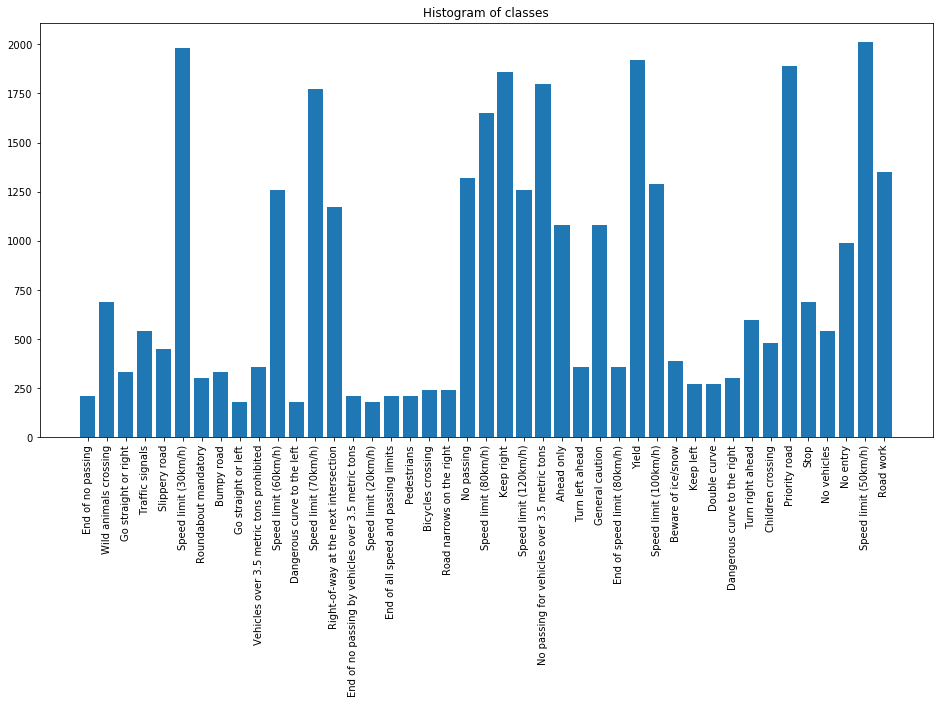

Visualization of training class frequencies after equalisation:


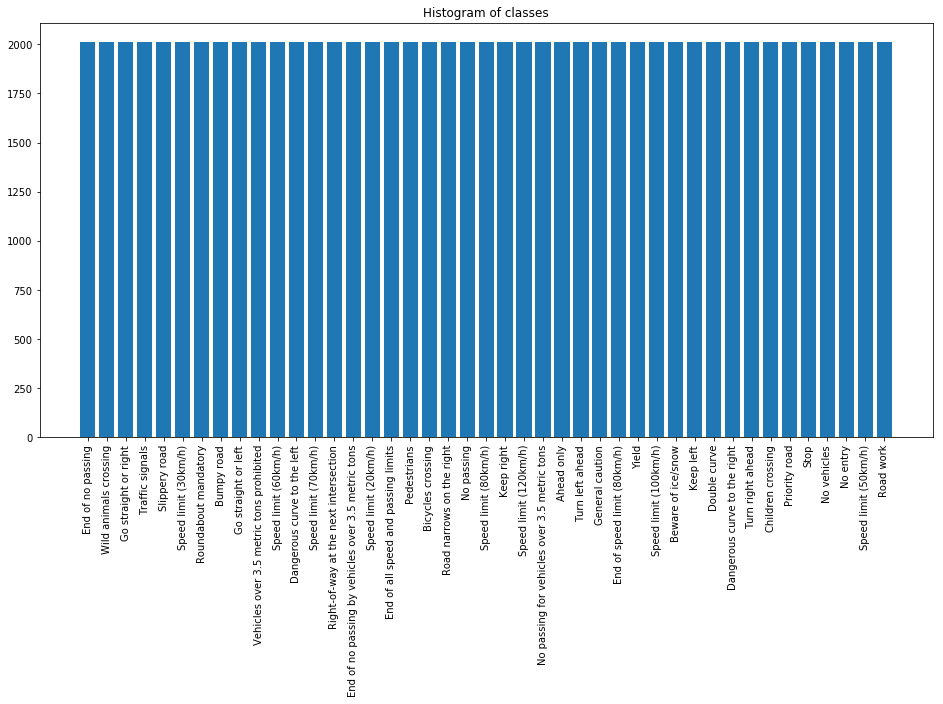

Visualization of validation class frequencies:


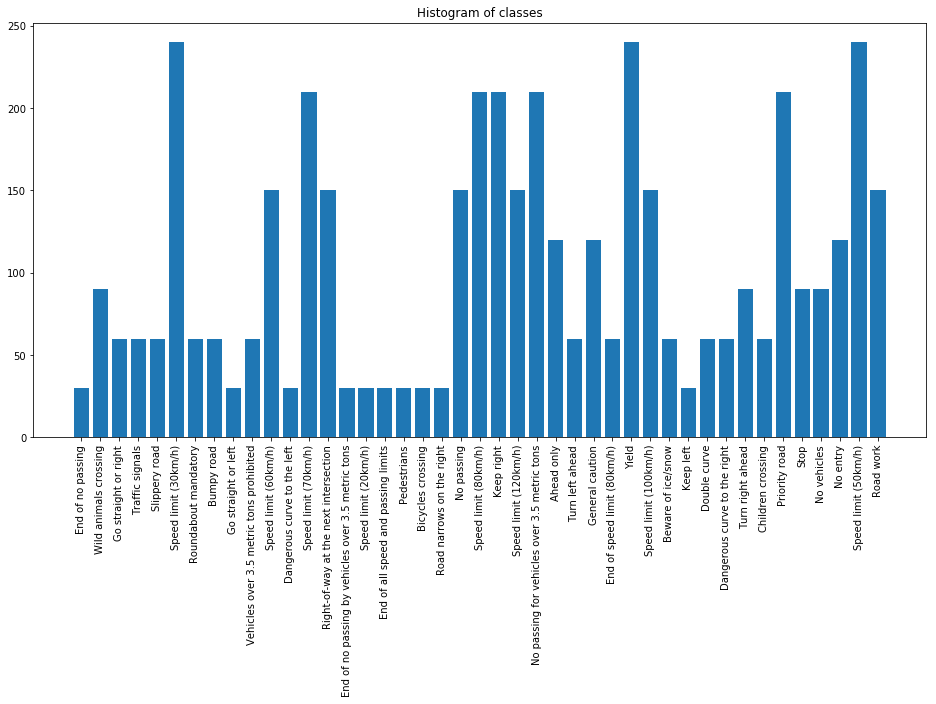

Visualization of some images of all classes:


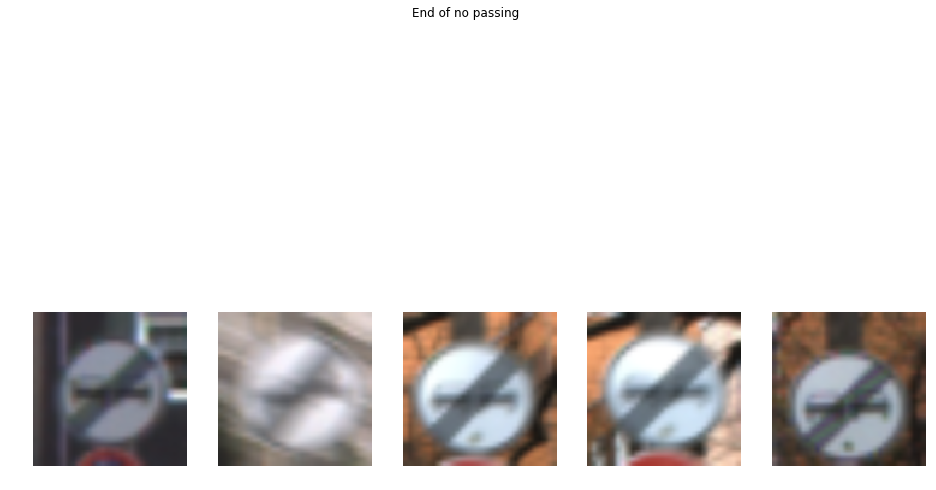

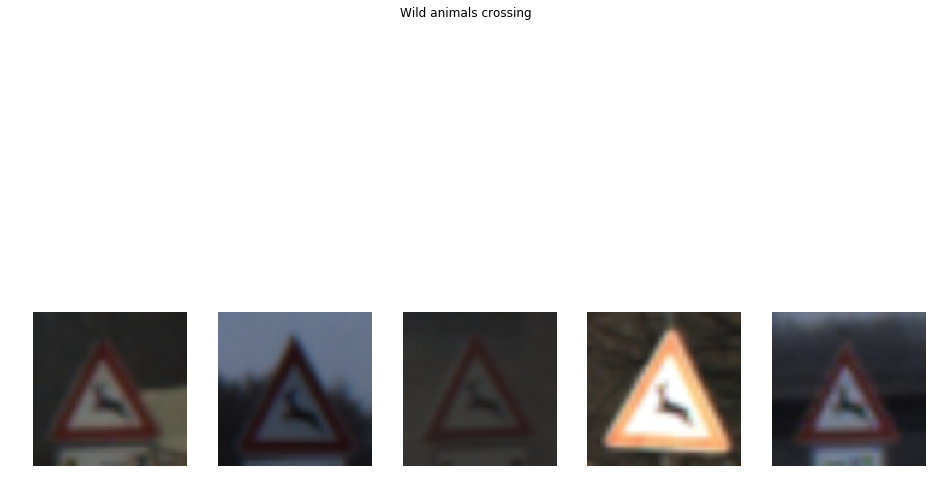

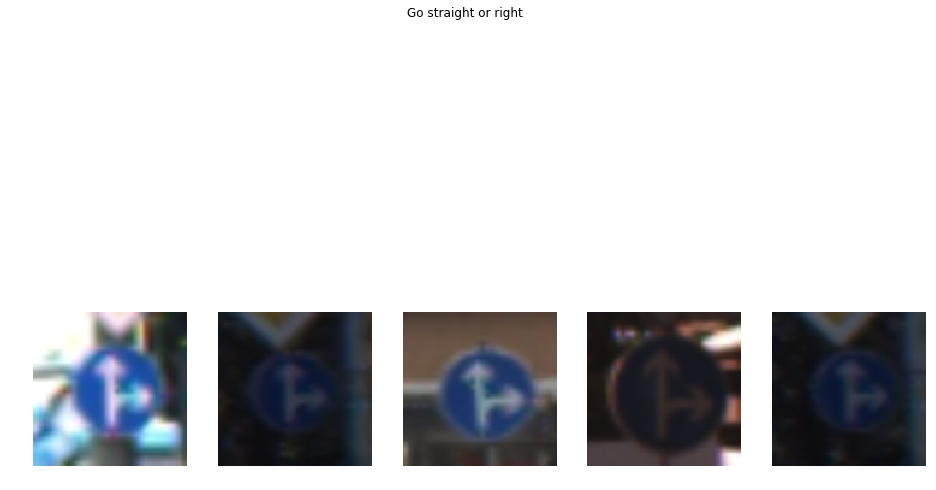

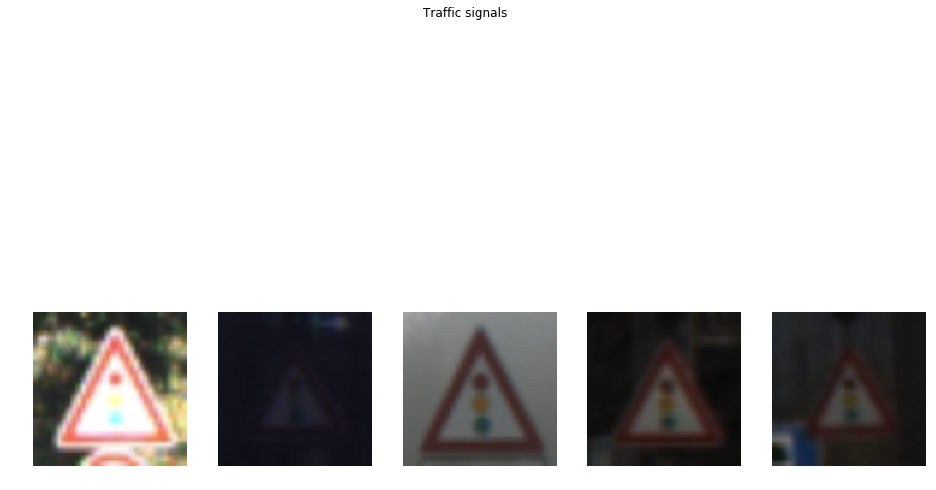

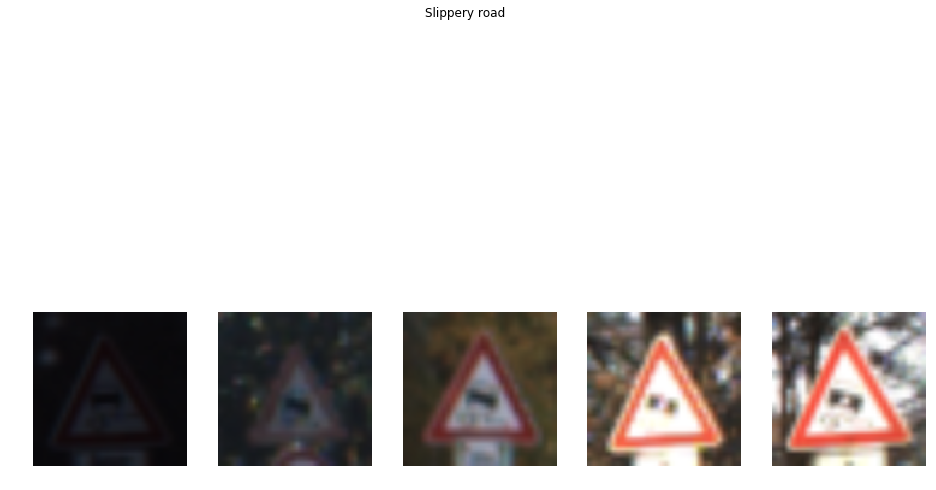

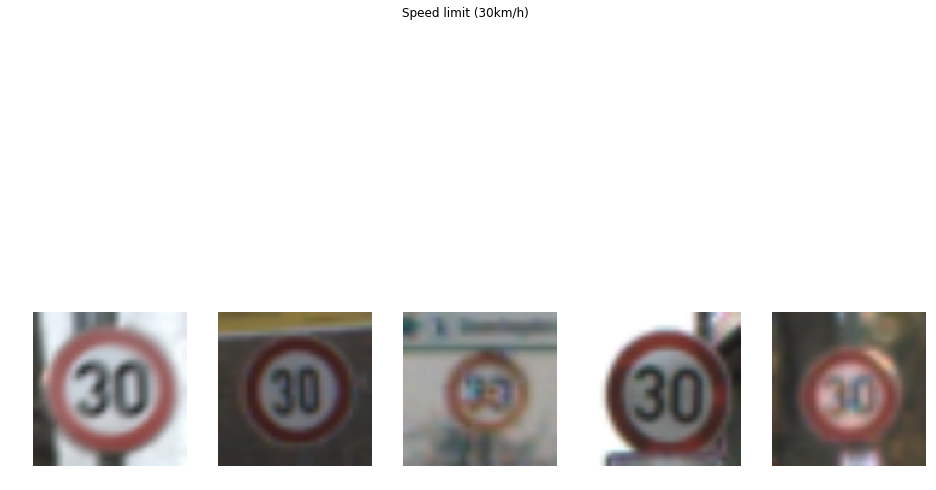

Visualization image augmentation:


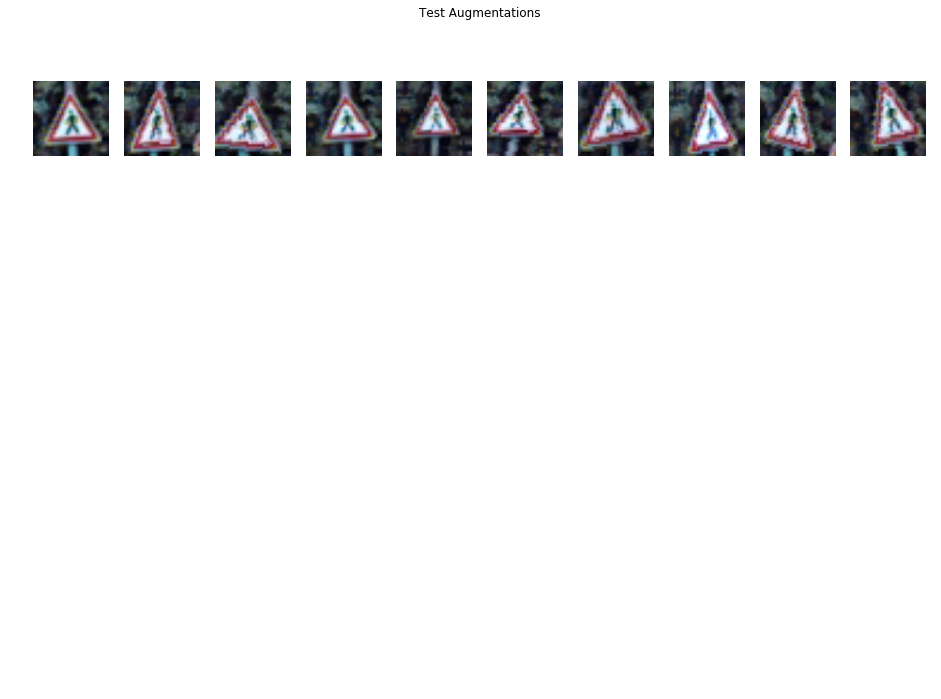

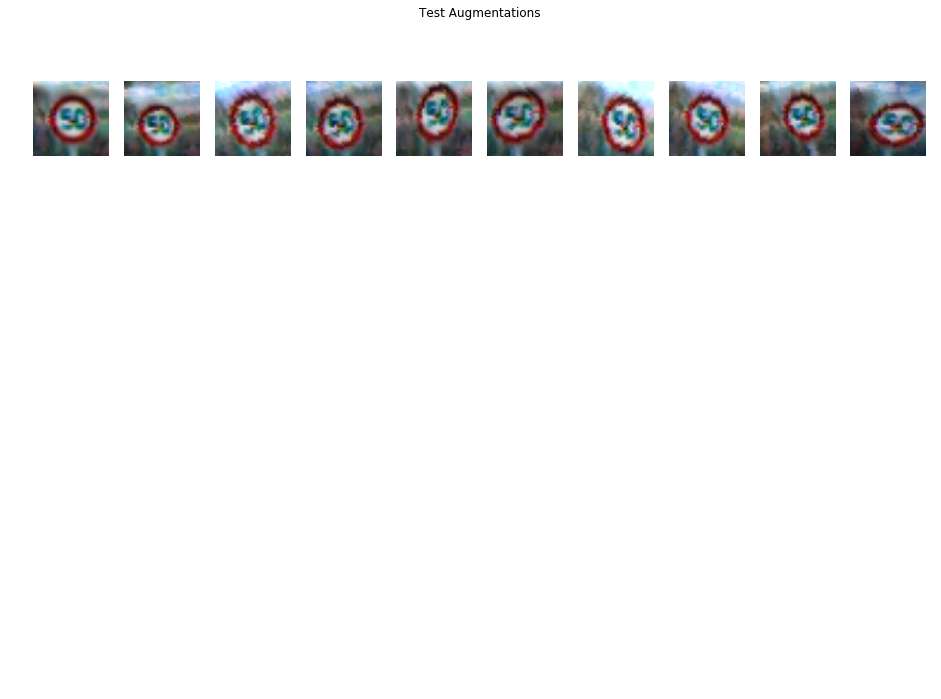

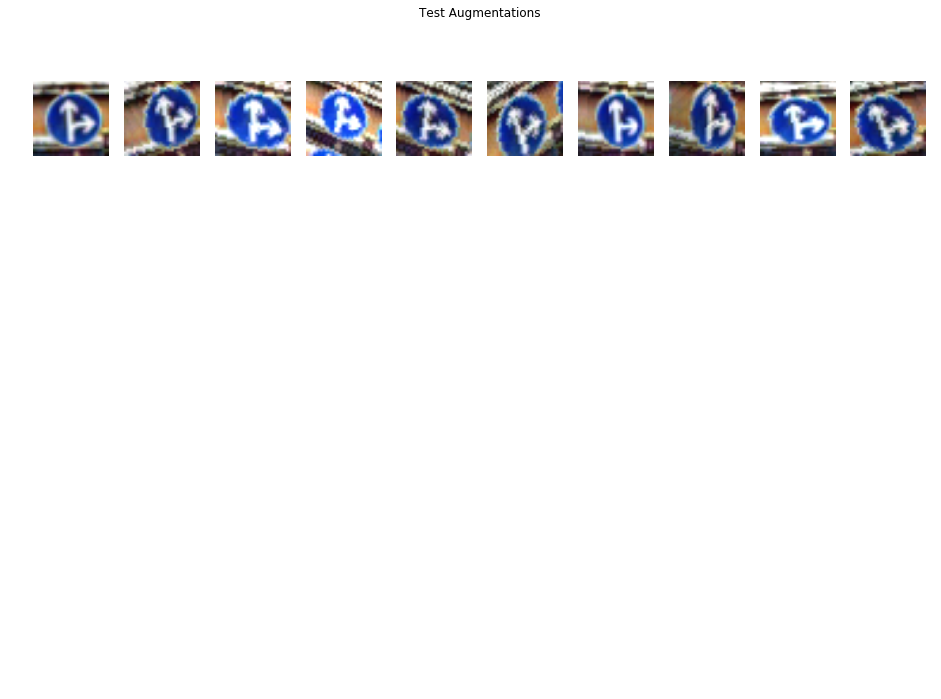

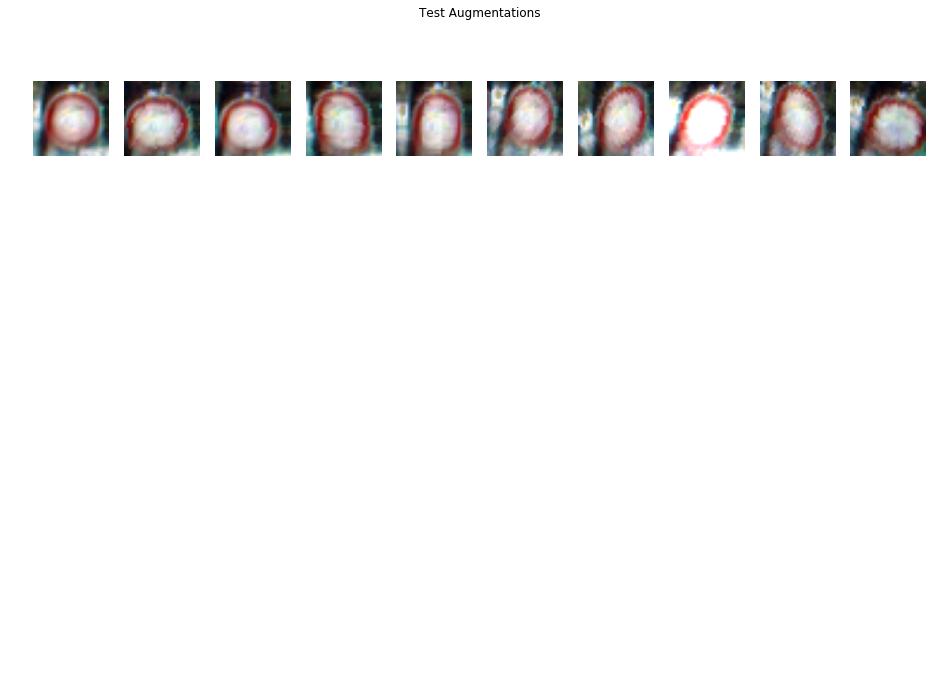

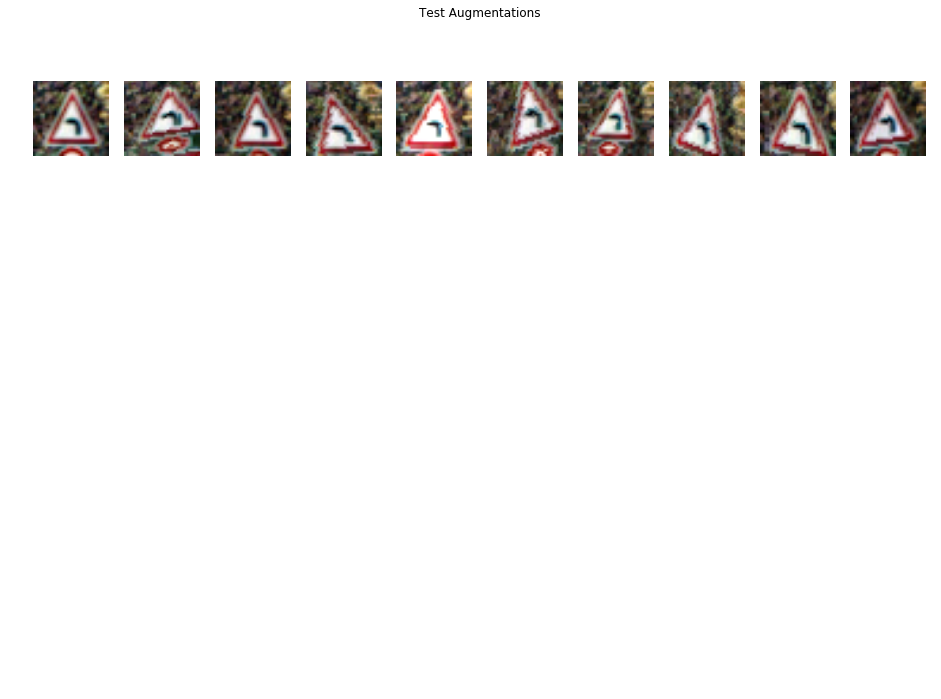

In [12]:
# For creation of the custom traffic sign images dataset
# util.create_dataset('images/custom_signs', 'custom_test.p')


# Train a model
# ---------------------------------------------------------------------------------------------------------

# Instantiate the ModelTrainer !
trainer = ModelTrainer(log_directory='logs',
                       path_to_traindata='datasets/train.p',
                       path_to_valdata='datasets/valid.p',
                       translations_file='signnames.csv')

# The preprocessing function will be a lambda function that calls some functions of the image_preprocessor
trainer.set_preprocessing_function((lambda x: trainer.image_preprocessor.normalize_center(
    trainer.image_preprocessor.apply_clahe(x))))

# The augmentation function is also a lambda function that uses the internal image augmenter of the ModelTrainer
trainer.set_augmentation_function((lambda x: trainer.image_augmenter.process(x)))

# Set the parameter of this training process.
trainer.set_training_parameter(learning_rate=1e-3, batch_size=128, epochs=50, optimizer='adam')

# Print out some information about the datasets
print('Training set statistics:')
trainer.print_dataset_statistics(dataset_name='train')

print('Validation set statistics:')
trainer.print_dataset_statistics(dataset_name='val')

# Print frequencies
print('Visualization of training class frequencies:')
trainer.visualize_dataset_frequencies(dataset_name='train')

# Print frequencies after equalisation
trainer.equalize_traindata_class_frequencies()
print('Visualization of training class frequencies after equalisation:')
trainer.visualize_dataset_frequencies(dataset_name='train')

# Print frequencies
print('Visualization of validation class frequencies:')
trainer.visualize_dataset_frequencies(dataset_name='val')

# Visualize some images
print('Visualization of some images of all classes:')
trainer.visualize_dataset_images(dataset_name='train')

# Visualize Augmentation
print('Visualization image augmentation:')
trainer.visualize_image_augmentation()

## Step 6: Train the Deep Learning Model

Now it is time to fit the Model to the Training-Data. This is done by calling trainer.fit(). Looks nearly like keras.

In [2]:
# Get the shape of the training images
input_shape = trainer.get_image_shape()

# Get the count of classes from the ModelTrainer
num_classes = trainer.get_num_classes()

# Define the model to train
custom_squeezenet = models.TfCustomSqueezeNet(input_shape=[None,
                                                           input_shape[0],
                                                           input_shape[1],
                                                           input_shape[2]],
                                              n_classes=num_classes,
                                              kernel_regularization=0.01,
                                              dropout_training_value=0.5)
# Set the model to the ModelTrainer
trainer.set_model(custom_squeezenet)

# Fit the model with the specified optimizer to the training set
trainer.fit(experiment_name='final_experiment')

# Evaluate on the validation set
trainer.evaluation_run(display_most_unsure=10, detailed_view=False)

# Get the last (best) Checkpoint filename
last_checkpoint = trainer.get_last_checkpoint_filename()

# Clear the Session Graph
tf.reset_default_graph()

NameError: name 'trainer' is not defined

## Step 6: Load the last checkpoint and run the test-set.

This code is run when all experiments have finished and my training statistics look nice for training accuracy and validation accuracy and loss. If the model has enough parameters but does not overfit, or overfitting could be prevented by weight decay, dropout or other regularization-methods, and all statistics are nice - then I finally run the test-set. Only once.


In [ ]:
# Load a model and evaluate the test-set
# ---------------------------------------------------------------------------------------------------------

trainer = ModelTrainer(log_directory='logs',
                       path_to_traindata='datasets/train.p',
                       path_to_valdata='datasets/test.p',
                       translations_file='signnames.csv')

# The preprocessing function will be a lambda function that calls some functions of the image_preprocessor
trainer.set_preprocessing_function((lambda x: trainer.image_preprocessor.normalize_center(
    trainer.image_preprocessor.apply_clahe(x))))

# The augmentation function is also a lambda function that uses the internal image augmenter of the ModelTrainer
trainer.set_augmentation_function((lambda x: trainer.image_augmenter.process(x)))

# Set the parameter of this training process.
trainer.set_training_parameter(learning_rate=1e-3, batch_size=128, epochs=50, optimizer='adam')

# Get the shape of the training images
input_shape = trainer.get_image_shape()

# Get the count of classes from the ModelTrainer
num_classes = trainer.get_num_classes()

# Define the model to train
custom_squeezenet = models.TfCustomSqueezeNet(input_shape=[None,
                                                           input_shape[0],
                                                           input_shape[1],
                                                           input_shape[2]],
                                              n_classes=num_classes,
                                              kernel_regularization=0.01,
                                              dropout_training_value=0.5)
# Set the model to the ModelTrainer
trainer.set_model(custom_squeezenet)

# Load the last checkpoint from previous training
trainer.load_weights(last_checkpoint)

# Evaluate on the validation set
trainer.evaluation_run(display_most_unsure=10, detailed_view=False)

# Clear the Session Graph
tf.reset_default_graph()

## Step 7: Test the model on other images

In [ ]:
# Load a model and evaluate the custom test-set
# ---------------------------------------------------------------------------------------------------------

trainer = ModelTrainer(log_directory='logs',
                       path_to_traindata='datasets/train.p',
                       path_to_valdata='datasets/custom_test.p',
                       translations_file='signnames.csv')

# The preprocessing function will be a lambda function that calls some functions of the image_preprocessor
trainer.set_preprocessing_function((lambda x: trainer.image_preprocessor.normalize_center(
    trainer.image_preprocessor.apply_clahe(x))))

# The augmentation function is also a lambda function that uses the internal image augmenter of the ModelTrainer
trainer.set_augmentation_function((lambda x: trainer.image_augmenter.process(x)))

# Set the parameter of this training process.
trainer.set_training_parameter(learning_rate=1e-3, batch_size=128, epochs=50, optimizer='adam')

# Get the shape of the training images
input_shape = trainer.get_image_shape()

# Get the count of classes from the ModelTrainer
num_classes = trainer.get_num_classes()

# Define the model to train
custom_squeezenet = models.TfCustomSqueezeNet(input_shape=[None,
                                                           input_shape[0],
                                                           input_shape[1],
                                                           input_shape[2]],
                                              n_classes=num_classes,
                                              kernel_regularization=0.01,
                                              dropout_training_value=0.5)
# Set the model to the ModelTrainer
trainer.set_model(custom_squeezenet)

# Load the last checkpoint from previous training
trainer.load_weights(last_checkpoint)

# Evaluate on the validation set
trainer.evaluation_run(display_most_unsure=10, detailed_view=True)

# Clear the Session Graph
tf.reset_default_graph()

In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")